In [1]:
import anndata as ad
import scanpy as sc
import gc
import sys
import cellanova as cnova
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea

seed = 10
np.random.seed(seed)

In [2]:
def run_cell_anova(adata, batch_key, condition_key, control_name, cell_type_label, dataset_name):
    adata.raw=None
    if np.max(adata.X) > 15:
        sc.pp.filter_cells(adata, min_genes=300)
        sc.pp.filter_genes(adata, min_cells=10)

        sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
        sc.pp.log1p(adata)

    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata, n_top_genes=3000, batch_key=batch_key)
        adata = adata[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata, n_top_genes=adata.shape[1], batch_key=batch_key)

    import warnings
    print(adata.X[:10,:10])
    # Suppress all warnings
    warnings.filterwarnings("ignore")

    integrate_key = batch_key
    adata.obs['dataidx'] = adata.obs[batch_key].copy()
    #adata_prep = cnova.model.preprocess_data(adata, integrate_key='dataidx')

    batch = np.unique(adata.obs[integrate_key])
    list_batch = []
    for x in batch:
        adata_iter = adata[adata.obs[integrate_key] == x]
        list_batch.append(adata_iter)

    adata_prep = ad.concat(list_batch)
    adata_prep.layers['lognorm'] = adata_prep.X
    
    if adata.shape[1] > 3000:
        sc.pp.highly_variable_genes(adata_prep, n_top_genes=3000, batch_key=batch_key)
        adata_prep = adata_prep[:, adata.var["highly_variable"]].copy()
    else:
        sc.pp.highly_variable_genes(adata_prep, n_top_genes=adata.shape[1], batch_key=batch_key)
    
    sc.pp.scale(adata_prep)
    adata_prep.layers['scale'] = adata_prep.X

    control_batches = list(set(adata_prep[adata_prep.obs[condition_key] == control_name,].obs[batch_key]))
    control_dict = {
        'g1': control_batches,
    }
    adata_prep = cnova.model.calc_ME(adata_prep, integrate_key='dataidx')
    adata_prep = cnova.model.calc_BE(adata_prep, integrate_key, control_dict)
    adata_prep = cnova.model.calc_TE(adata_prep, integrate_key)
    print(control_dict)
    adata_prep.obs['PseudoState'] = adata_prep.obs[condition_key].copy()
    adata_prep.write_h5ad("./cellanova/" + dataset_name + "_results.h5ad")

    integrated = ad.AnnData(adata_prep.layers['denoised'], dtype=np.float32)
    integrated.obs = adata_prep.obs.copy()
    integrated.var_names = adata_prep.var_names

    sc.pp.pca(integrated)
    sc.pp.neighbors(integrated, n_neighbors=15, n_pcs=30)
    sc.tl.umap(integrated)
    if cell_type_label is not None:
        sc.pl.umap(integrated, color=['dataidx', cell_type_label], ncols=1)
    else:
        sc.pl.umap(integrated, color='dataidx')

    res = cnova.utils.calc_oobNN(integrated, batch_key='dataidx', condition_key='PseudoState')
    df = res.obsm['knn_prop']
    df['condition'] = res.obs['PseudoState']
    df = df.reset_index()
    df = pd.melt(df, id_vars=['index', 'condition'], var_name='neighbor', value_name='proportion')
    df = df.rename(columns={'index': 'obs_name'})
    df.to_csv("./cellanova/" + dataset_name + "_oobNN.csv")

    g = sea.FacetGrid(df, col='neighbor', hue='condition')
    g.map(sea.kdeplot, 'proportion', bw_adjust=2, alpha=1)
    g.set(xlabel='NN proportion', ylabel='Density')
    g.add_legend()
    plt.suptitle('CellANOVA integration')
    sea.set_style('white')
    plt.show()

# Type 1 diabetes

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE148073

2025-01-05 16:14:55,501 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-05 16:14:59,464 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-05 16:14:59,609 - harmonypy - INFO - Iteration 1 of 30
2025-01-05 16:15:11,799 - harmonypy - INFO - Iteration 2 of 30
2025-01-05 16:15:24,012 - harmonypy - INFO - Iteration 3 of 30
2025-01-05 16:15:36,350 - harmonypy - INFO - Iteration 4 of 30
2025-01-05 16:15:48,572 - harmonypy - INFO - Iteration 5 of 30
2025-01-05 16:16:00,789 - harmonypy - INFO - Converged after 5 iterations


{'g1': ['HPAP034', 'HPAP047', 'HPAP036', 'HPAP035', 'HPAP026', 'HPAP042', 'HPAP037', 'HPAP040', 'HPAP039', 'HPAP022', 'HPAP044']}


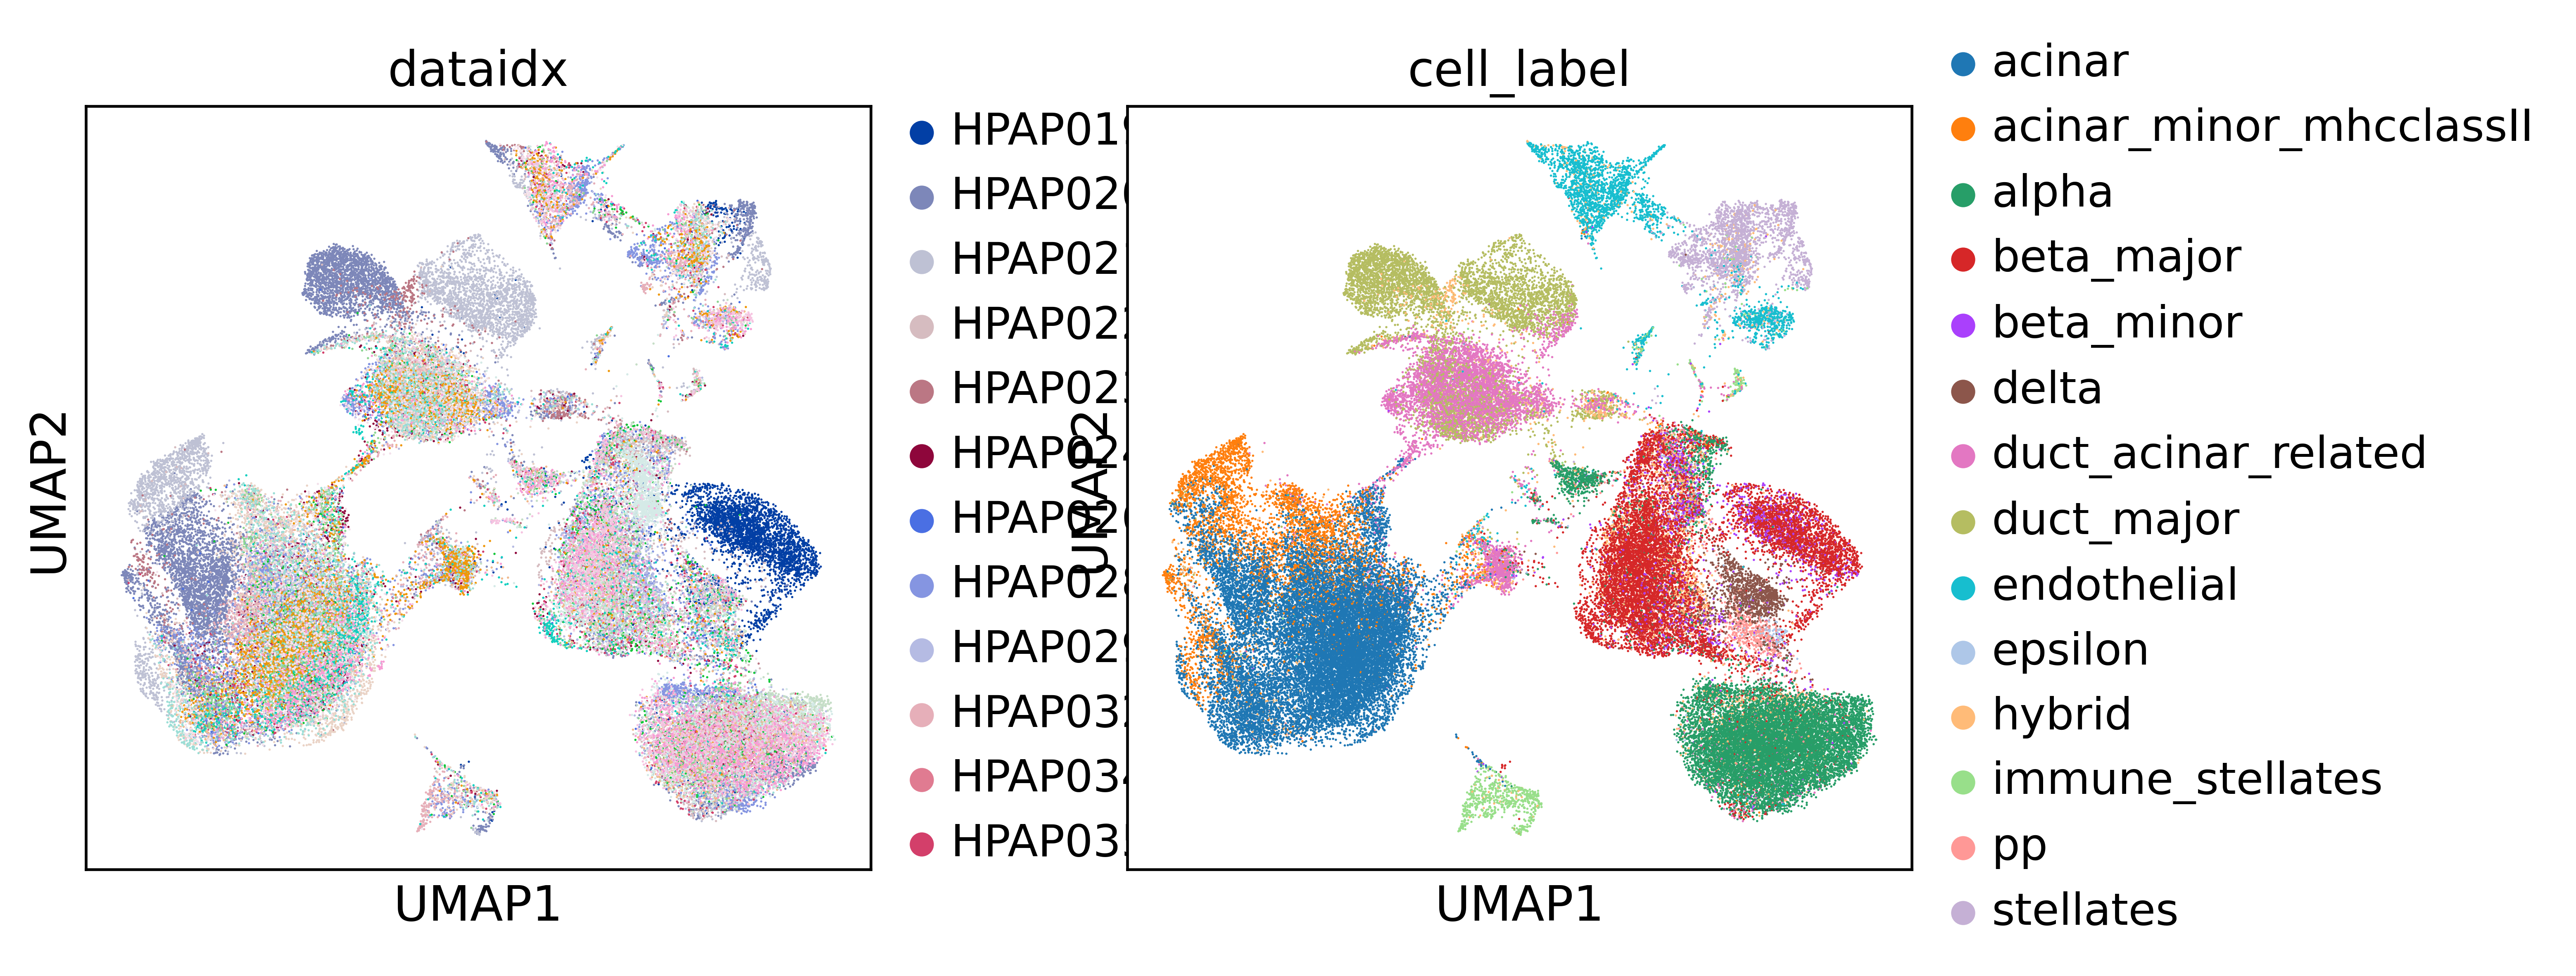

In [ ]:
adata = sc.read_h5ad('../case_control/data/t1d.h5ad')
run_cell_anova(adata=adata, batch_key="donor_id", condition_key="disease_state", control_name='Control', cell_type_label='cell_label', dataset_name="t1d")

# Human kidney multiomics atlas

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE211785

  (0, 0)	2.2007880210876465
  (0, 5)	2.2007880210876465
  (0, 6)	2.8369860649108887
  (1, 5)	3.0531344413757324
  (3, 1)	3.086092233657837
  (9, 6)	1.8467254638671875
  (9, 7)	2.457711696624756


2025-01-15 18:31:21,298 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-01-15 18:31:43,521 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-01-15 18:31:47,805 - harmonypy - INFO - Iteration 1 of 30
2025-01-15 18:33:26,932 - harmonypy - INFO - Iteration 2 of 30
2025-01-15 18:35:11,489 - harmonypy - INFO - Iteration 3 of 30
2025-01-15 18:37:04,200 - harmonypy - INFO - Converged after 3 iterations


{'g1': ['HK1588.SC', 'HK2891.SC', 'HK2893.SN', 'HK1585.SC', 'HK2899.SN', 'HK2896.SC', 'HK2891.SN', 'HK1664_G.SC', 'HK2893.SC', 'HK2895.SN', 'HK2833.SC', 'HK2924.SC', 'HK2923.SC', 'HK2899.SC', 'HK1664_T.SC', 'HK2867.SN', 'HK2713.SC', 'HK2867.SC', 'HK2770_SN', 'HK1997.SC', 'HK2895.SC', 'HK2833.SN', 'HK2662.SC', 'HK2898.SN']}


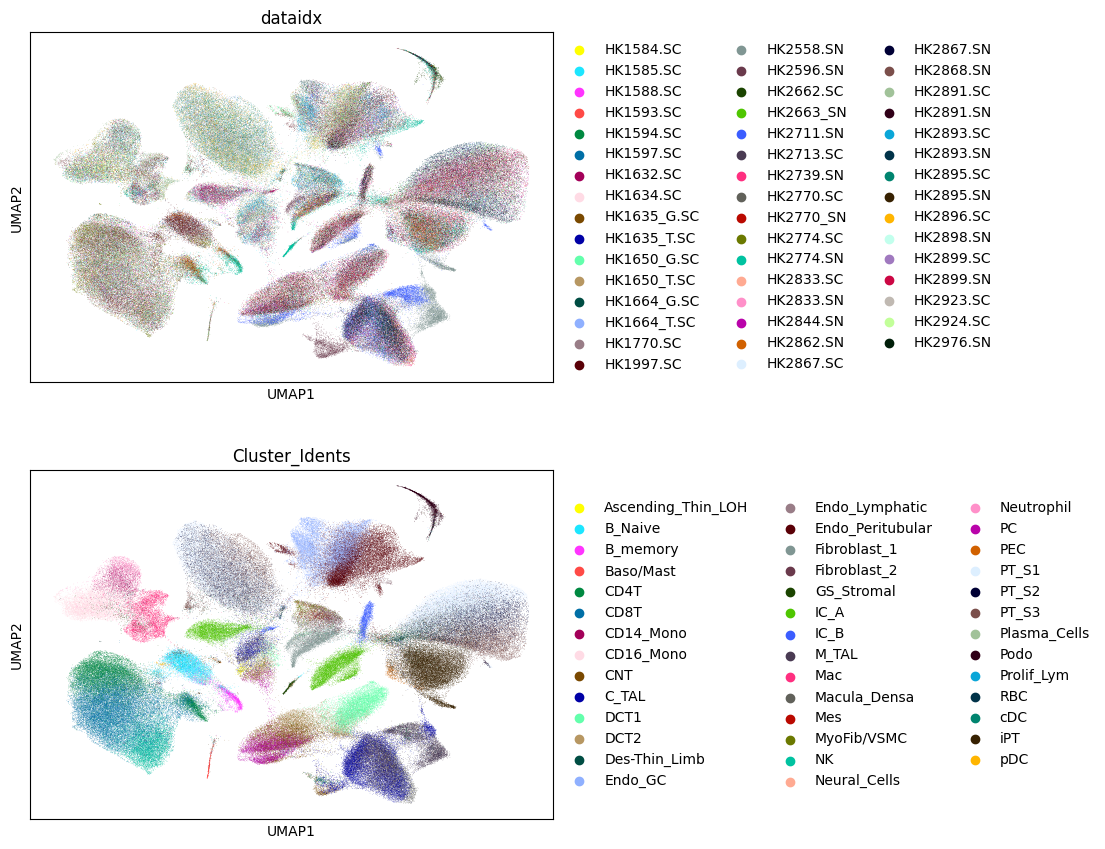

KeyboardInterrupt: 

In [3]:
adata=sc.read_h5ad("../case_control/data/GSE211785_Susztak_SC_SN_ATAC_merged_PreSCVI_final.h5ad")
adata=adata[adata.obs["tech"].isin(['SC_RNA','SN_RNA'])].copy()
run_cell_anova(adata=adata, batch_key="orig_ident", condition_key="Status", control_name='Control', cell_type_label='Cluster_Idents', dataset_name="kidney")

# Mouse radiation experiment dataset

https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE280883

In [ ]:
adata=sc.read_h5ad("../case_control/data/mouse.h5ad")
run_cell_anova(adata=adata, batch_key='real_batch', condition_key="sample", control_name='C', cell_type_label='compartment', dataset_name="mouse")

# SEA-AD dataset

https://cellxgene.cziscience.com/collections/1ca90a2d-2943-483d-b678-b809bf464c30

In [ ]:
adata=sc.read_h5ad("../case_control/data/AD.h5ad")
run_cell_anova(adata=adata, batch_key='donor_id', condition_key="disease", control_name='normal', cell_type_label='Subclass', dataset_name="AD")